In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Doing some basic numerical calculations that enter the bound.
Just to see how to balance factors against the right $\epsilon$s and $\delta$s so that we can actually get a reasonable result within $<1000000$ samples.

In [3]:
# input params
dim = np.array([2, 3, 6, 7, 10, 20, 22])  # common robot dofs.... 10 is base + arm, 20 is a PR2, 22 is a Movo
delta = np.linspace(start=0.0, stop=1.0, num=5)[1:]
epsilon = np.linspace(start=0.0, stop=2.0, num=5)[1:]


# some general helper methods to help us with our calculations
def compute_rho(_delta, _epsilon, _dim):
    """This is written a way that vectorized meshgrid computations can also be done."""
    _vols_unit_sphere = np.pi ** (_dim / 2) / scipy.special.gamma(_dim / 2 + 1)
    _vols_env = (1.0 + 2 * _delta) * (2 * _delta) ** (_dim - 1)
    _measures_unit_sphere = _vols_unit_sphere / _vols_env
    return _measures_unit_sphere * (_epsilon * _delta / np.sqrt(1 + _epsilon ** 2)) ** _dim


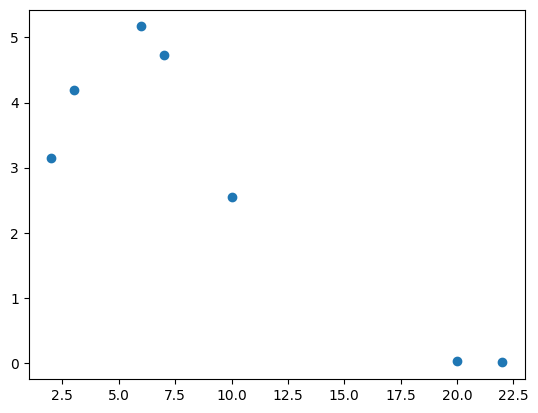

In [4]:
# https://en.wikipedia.org/wiki/Volume_of_an_n-ball
vol_unit_sphere = np.pi ** (dim / 2) / scipy.special.gamma(dim / 2 + 1)

plt.figure()
plt.scatter(dim, vol_unit_sphere)
plt.show()

In [5]:
# Given a range of delta clearances, look at volume of the straight line environment inside the walls
deltas, dims = np.meshgrid(delta, dim)
vol_env = (1.0 + 2 * deltas) * (2 * deltas) ** (dims - 1)
# Moving right along the columns is increasing delta, and moving downwards is increasing dimension
vol_env

array([[7.50000000e-01, 2.00000000e+00, 3.75000000e+00, 6.00000000e+00],
       [3.75000000e-01, 2.00000000e+00, 5.62500000e+00, 1.20000000e+01],
       [4.68750000e-02, 2.00000000e+00, 1.89843750e+01, 9.60000000e+01],
       [2.34375000e-02, 2.00000000e+00, 2.84765625e+01, 1.92000000e+02],
       [2.92968750e-03, 2.00000000e+00, 9.61083984e+01, 1.53600000e+03],
       [2.86102295e-06, 2.00000000e+00, 5.54209455e+03, 1.57286400e+06],
       [7.15255737e-07, 2.00000000e+00, 1.24697127e+04, 6.29145600e+06]])

In [6]:
# measure of unit ball
_, vols_unit_sphere = np.meshgrid(delta, vol_unit_sphere)
vols_unit_sphere / vol_env

array([[4.18879020e+00, 1.57079633e+00, 8.37758041e-01, 5.23598776e-01],
       [1.11701072e+01, 2.09439510e+00, 7.44673814e-01, 3.49065850e-01],
       [1.10244539e+02, 2.58385639e+00, 2.72208739e-01, 5.38303415e-02],
       [2.01590015e+02, 2.36238299e+00, 1.65917708e-01, 2.46081561e-02],
       [8.70455992e+02, 1.27508202e+00, 2.65342476e-02, 1.66026305e-03],
       [9.02016232e+03, 1.29034457e-02, 4.65652312e-06, 1.64075797e-08],
       [1.03046093e+04, 3.68521547e-03, 5.91066619e-07, 1.17149845e-09]])

From this we learn there are environments where balls are exceedingly voluminous, and some where there are not. I suspect we will need to pick experiments wisely with respect to how this volume looks.

The bound has four variables that determine the sample complexity and probability of correctness: the dimension (influencing the VC-dimension of the unit balls), the measure of the unit ball, epsilon, and delta.

We now do a large vectorized computation to compute all the possible bound results.

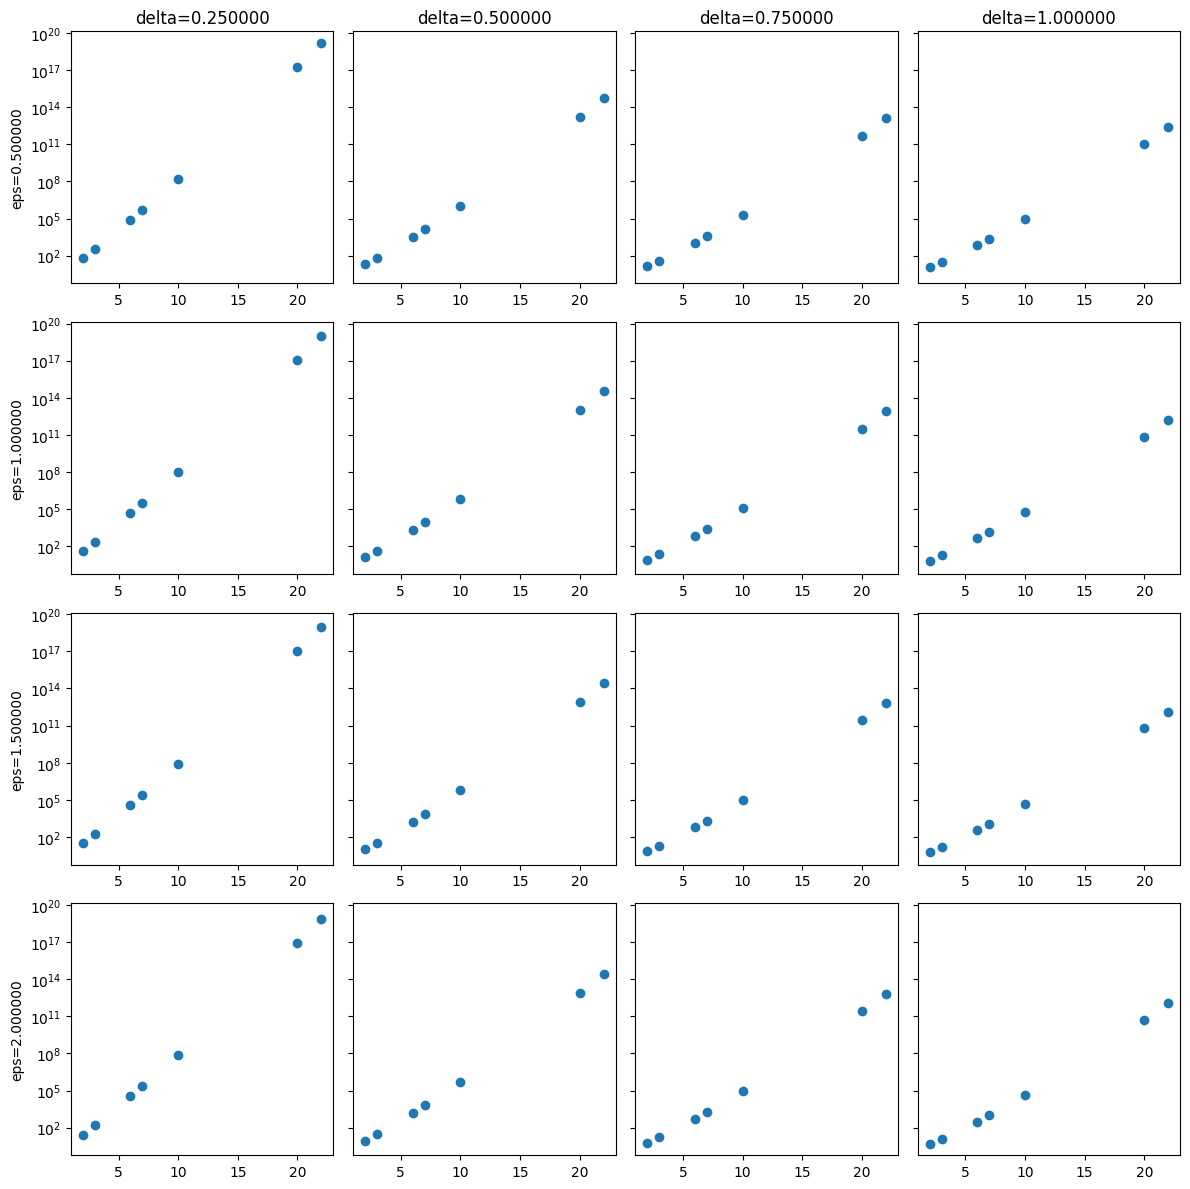

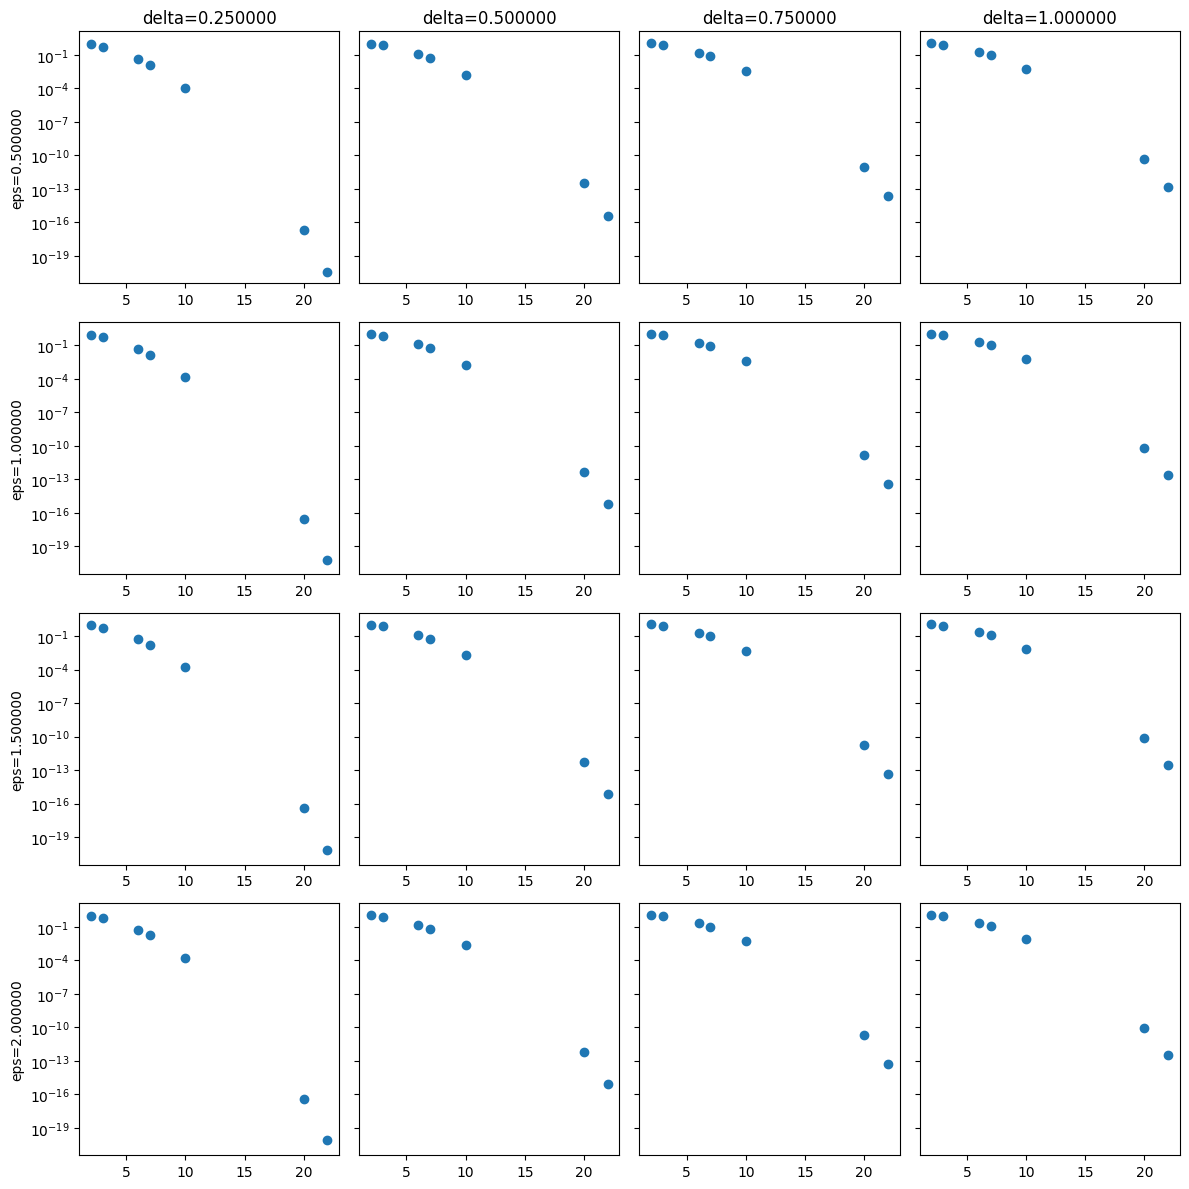

In [7]:
# first exploring the VC-dim threshold.
deltas, epsilons, dims = np.meshgrid(delta, epsilon, dim)
rhos = compute_rho(deltas, epsilons, dims)

# compute number of samples needed for VC and their associated probabilities to see if they are even useful
big_o_constant = 0.025
base_vc_samples = 8 * (dims + 1) / rhos * np.log(13 / rhos) * big_o_constant
# base_gammas = 2 * (rhos / 13) ** (2 * (dims + 1)) # directly from max bound
base_gammas = 2 * np.exp(-rhos * base_vc_samples / 4)

# plot and ed-grid across dimensions
fig, axs = plt.subplots(nrows=len(epsilon), ncols=len(delta), figsize=(12, 12), sharey=True)
for ri in range(len(epsilon)):
    for ci in range(len(dims)):
        if ri == 0:
            axs[ri, ci].set_title('delta=%f' % delta[ci])

        if ci == 0:
            axs[ri, ci].set_ylabel('eps=%f' % epsilon[ri])

        axs[ri, ci].scatter(dim, base_vc_samples[ci, ri, :])
        axs[ri, ci].set_yscale('log')
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=len(epsilon), ncols=len(delta), figsize=(12, 12), sharey=True)
for ri in range(len(epsilon)):
    for ci in range(len(dims)):
        if ri == 0:
            axs[ri, ci].set_title('delta=%f' % delta[ci])

        if ci == 0:
            axs[ri, ci].set_ylabel('eps=%f' % epsilon[ri])

        axs[ri, ci].scatter(dim, base_gammas[ci, ri, :])
        axs[ri, ci].set_yscale('log')
fig.tight_layout()
plt.show()


In [8]:
base_gammas[0, 0, :]

array([8.74557334e-01, 5.21105669e-01, 4.24355970e-02, 1.29692326e-02,
       1.17957195e-04, 2.00410136e-17, 3.63825443e-21])

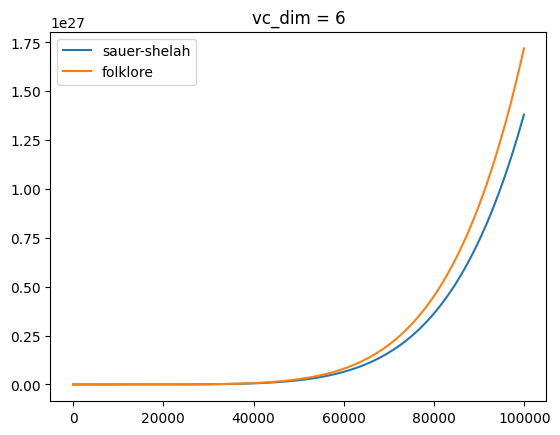

In [9]:
# Designing tractable experiments by just evaluating well-defined bounds on the shatter function.
vc_dim = 6

m_sample = np.arange(1, 100000, step=100)

# Sauer-Shelah combinatorial sum bound
_m, _d = np.meshgrid(m_sample, np.arange(vc_dim + 1))
ss_bound = np.sum(scipy.special.comb(_m, _d), axis=0)

# Folklore bound on Sauer shelah
flk_bound = (np.e * m_sample / vc_dim) ** vc_dim

plt.figure()
plt.plot(m_sample, ss_bound, label='sauer-shelah')
plt.plot(m_sample, flk_bound / 5, label='folklore')
plt.title('vc_dim = %i' % vc_dim)
plt.legend()
plt.show()

# it appears that these bounds are tight up to constants if you fix the dimension.
# even though it's harder to evaluate, we'll go with the original SS bound.

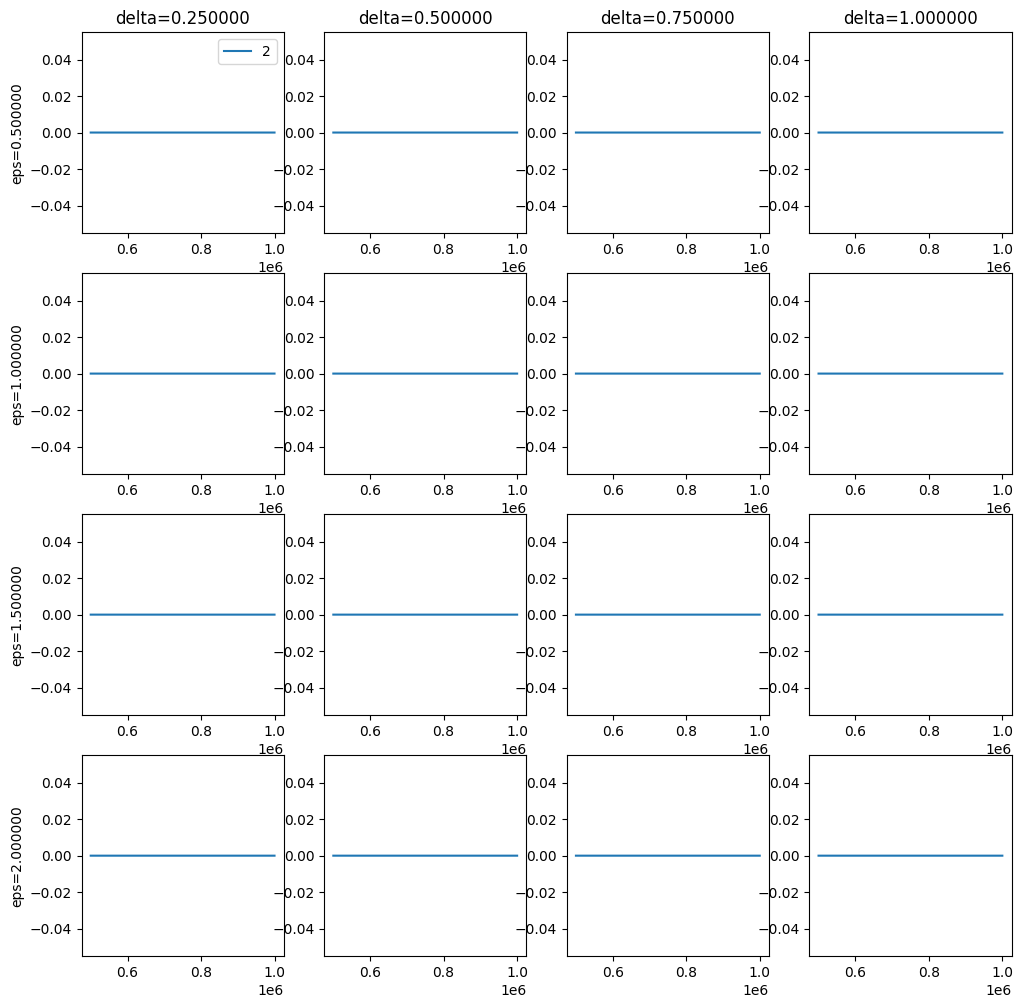

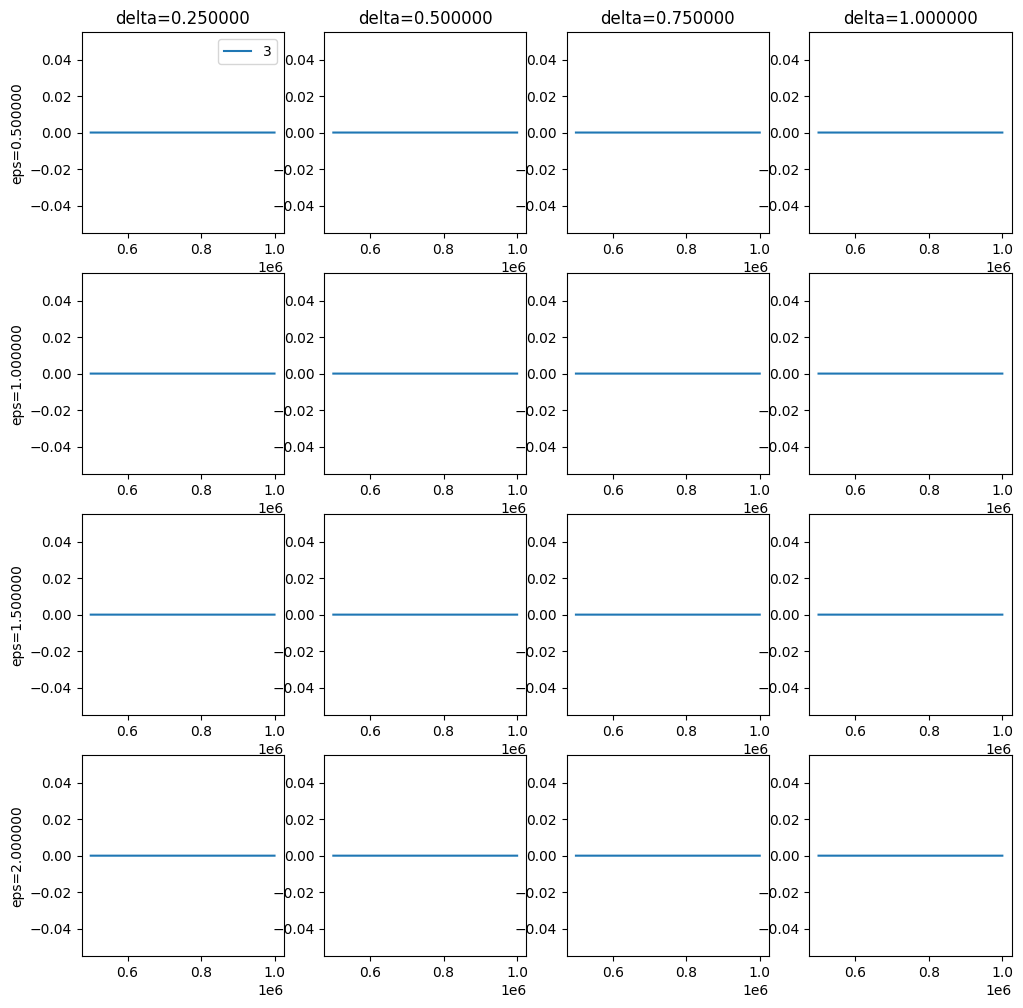

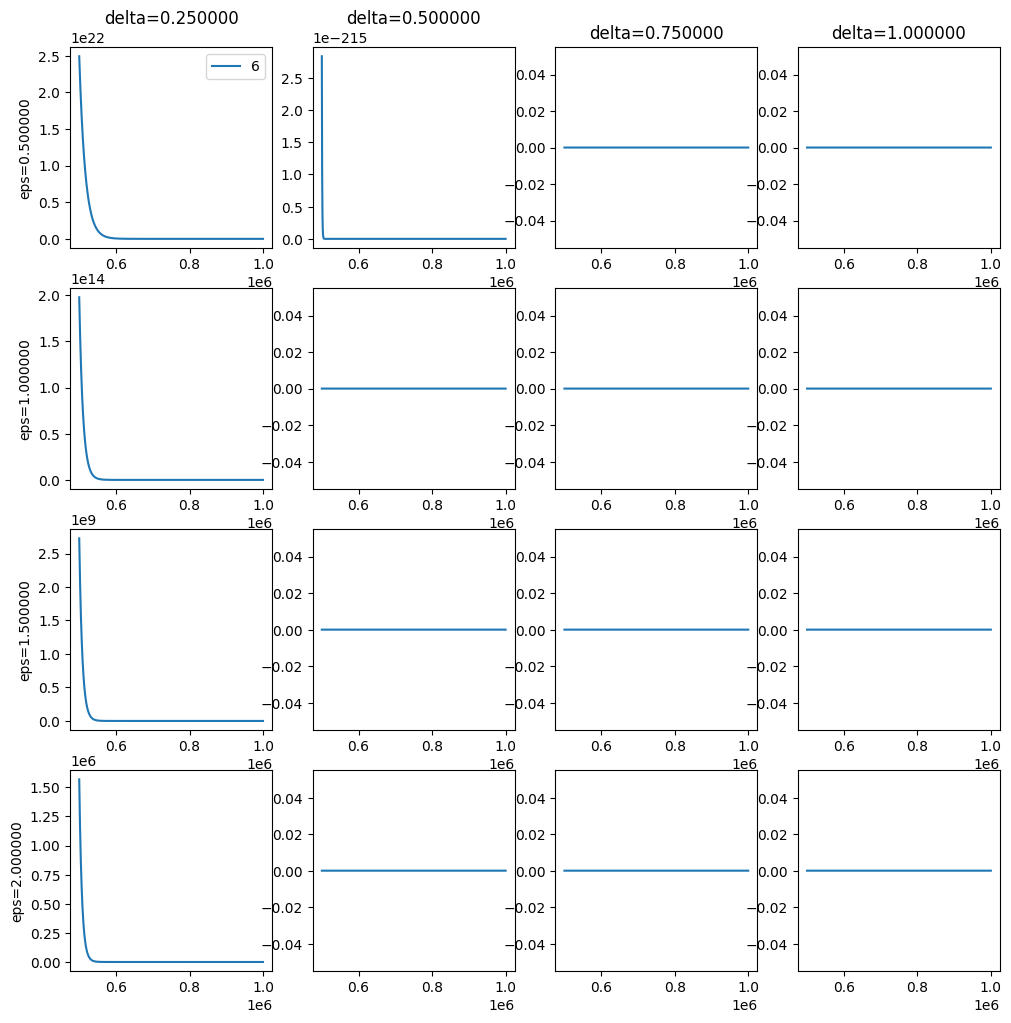

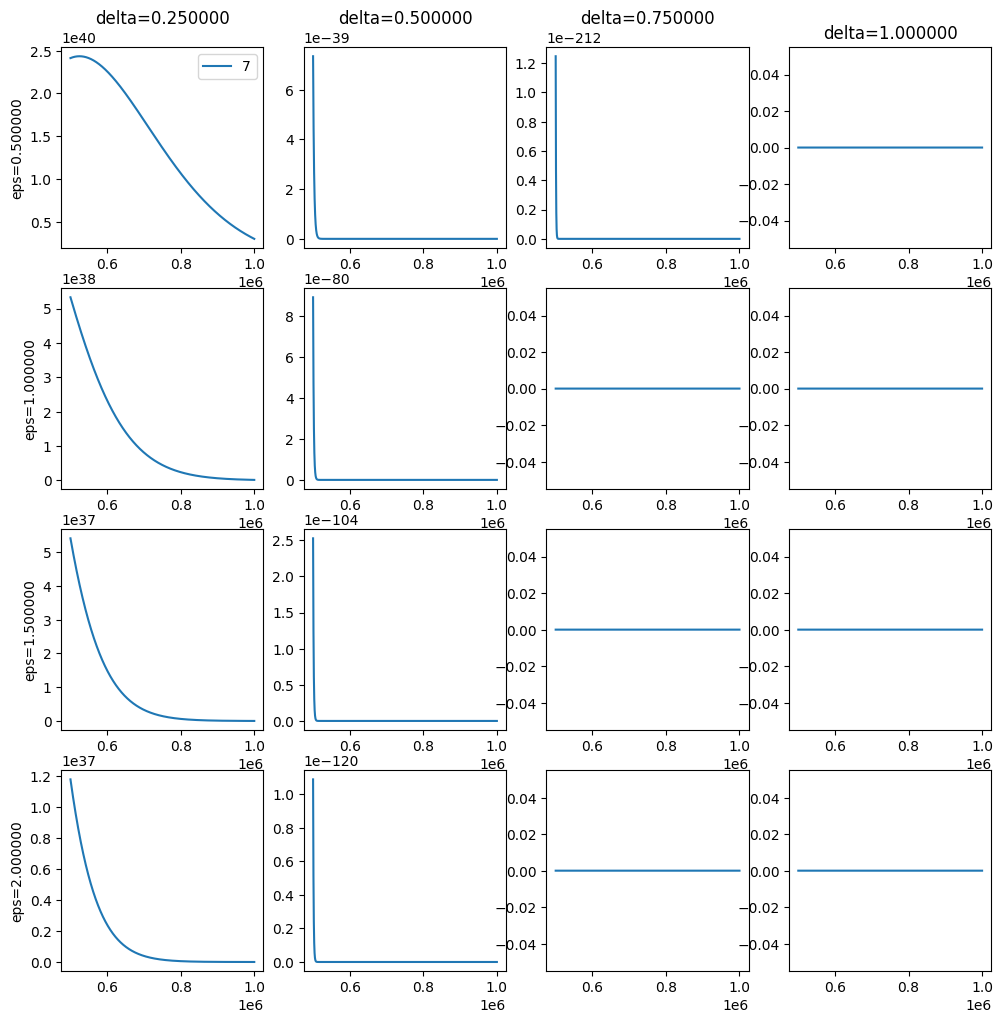

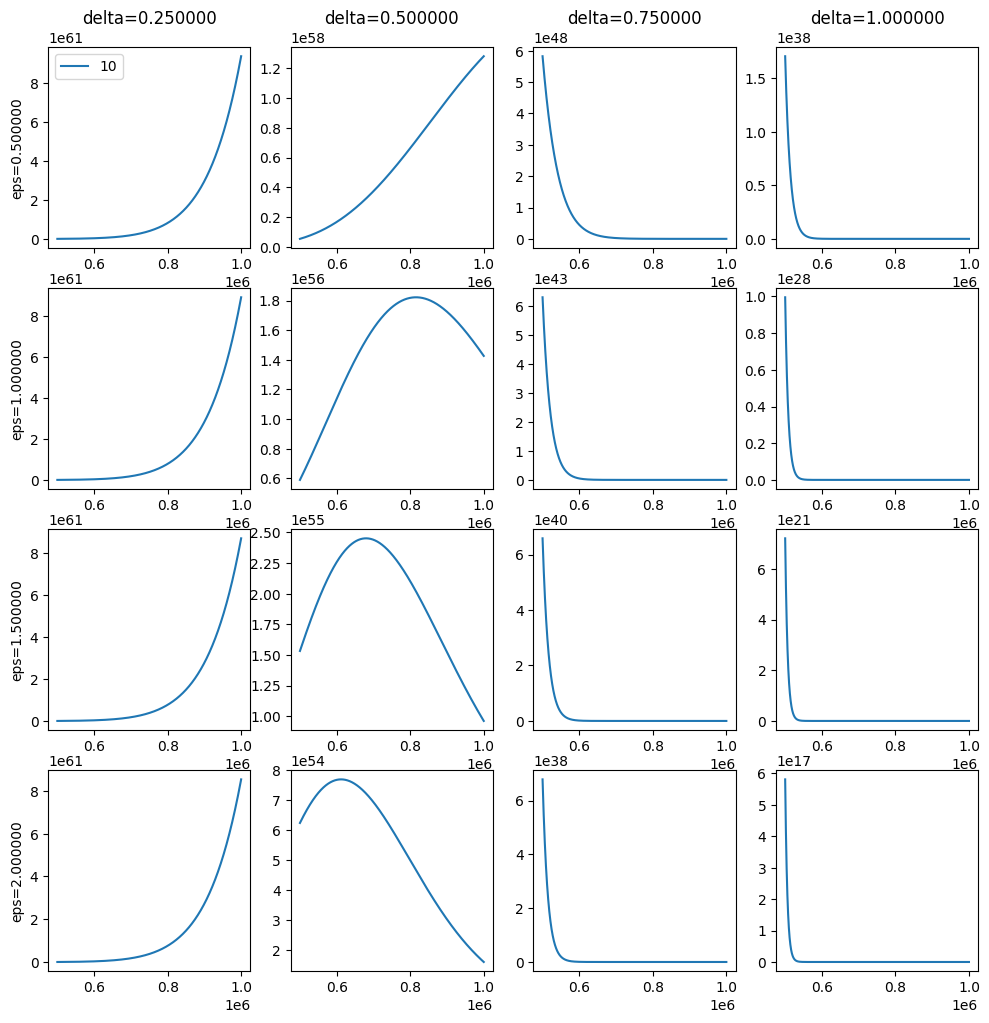

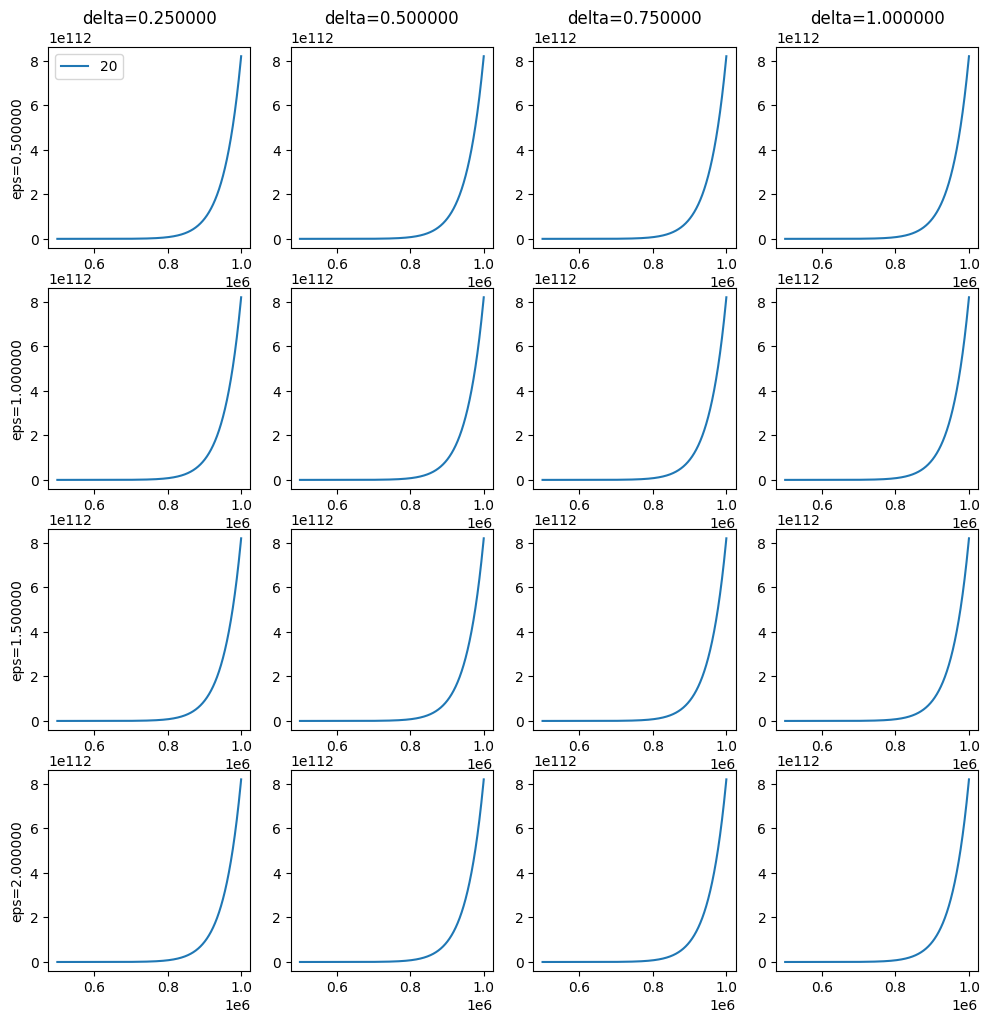

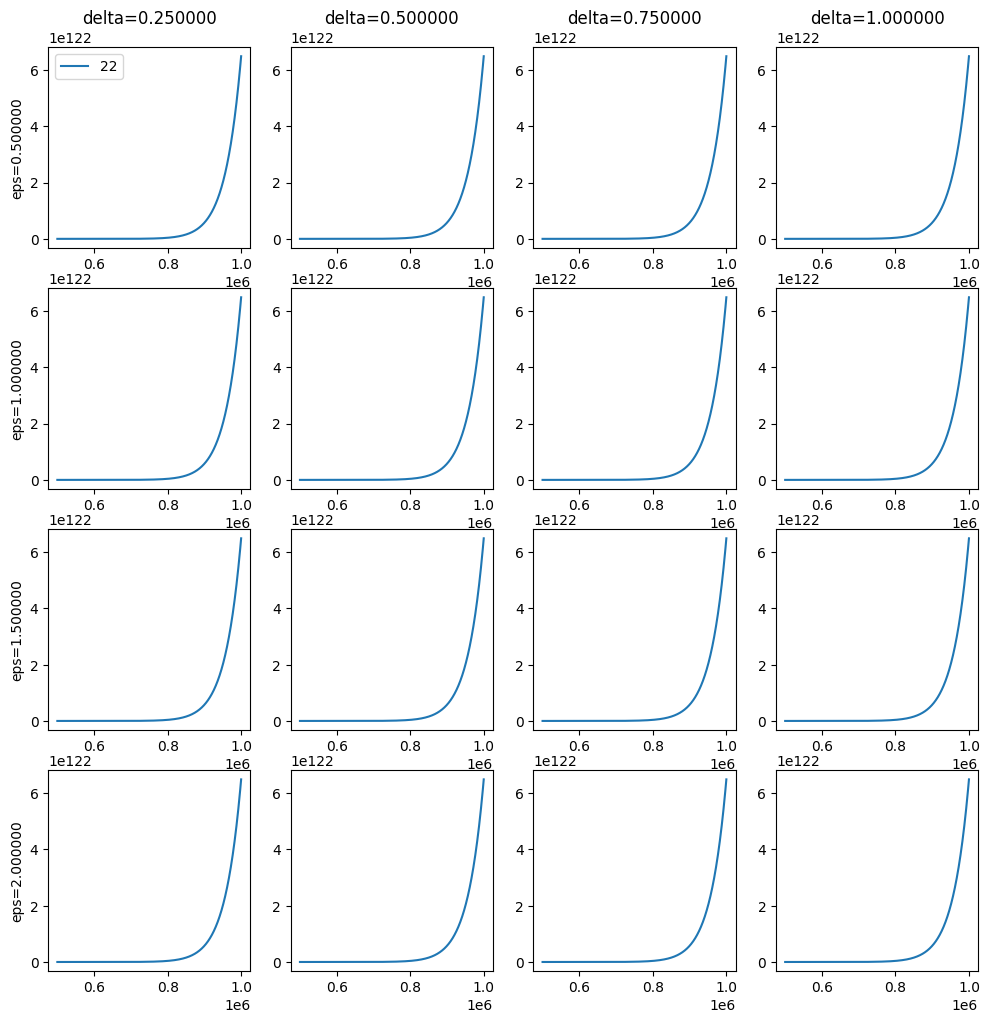

In [45]:
# compute the sample response curves per dimension using sauer-shelah shatter bound. may be easiest to do numerical curve inversion
# failure probabilities
sample = np.arange(499900, 1000000, step=10)
deltas, epsilons, dims, samples = np.meshgrid(delta, epsilon, dim, sample)

rhos = compute_rho(deltas, epsilons, dims)

# compute sauer-shelah bound factor
# this will be based on dims, and samples and will need to be reshaped for the meshgrid post-hoc.
ss_bounds_coll = []
for d in dim:
    _m, _d = np.meshgrid(2 * sample, np.arange(d + 2))  # + 2 because VC-dim of nd spheres is d + 1
    ss_bound = np.sum(scipy.special.comb(_m, _d), axis=0)
    ss_bounds_coll.append(ss_bound)

ss_bounds = np.stack(ss_bounds_coll)
ss_bounds = np.repeat(ss_bounds[np.newaxis, :, :], len(epsilon), axis=0)
ss_bounds = np.repeat(ss_bounds[np.newaxis, :, :, :], len(delta), axis=0)

# finally, compute gamma
gammas = 2 * ss_bounds * np.exp2(-rhos * samples / 2)

for i_d, d in enumerate(dim):
    fig, axs = plt.subplots(nrows=len(epsilon), ncols=len(delta), figsize=(12, 12))
    for ri in range(len(epsilon)):
        for ci in range(len(dims)):
            if ri == 0:
                axs[ri, ci].set_title('delta=%f' % delta[ci])

            if ci == 0:
                axs[ri, ci].set_ylabel('eps=%f' % epsilon[ri])

            axs[ri, ci].plot(samples[ci, ri, i_d, :], gammas[ci, ri, i_d, :], label=str(d))

    axs[0, 0].legend()
plt.show()

# yay! looks like we have a shot for low-dimensional systems (500 -1000), depending on the settings of epsilon and delta
# 


5.145544619321962e+99